**Player Age and Average Number of Hours Played are Predictive of Likelihood to Subsribe to a Newsletter**

Group: 008-31

Members: Matthew Choi, Elizaveta Lazareva, Bianca Swartz, Vicky Yang

**Visualization**

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


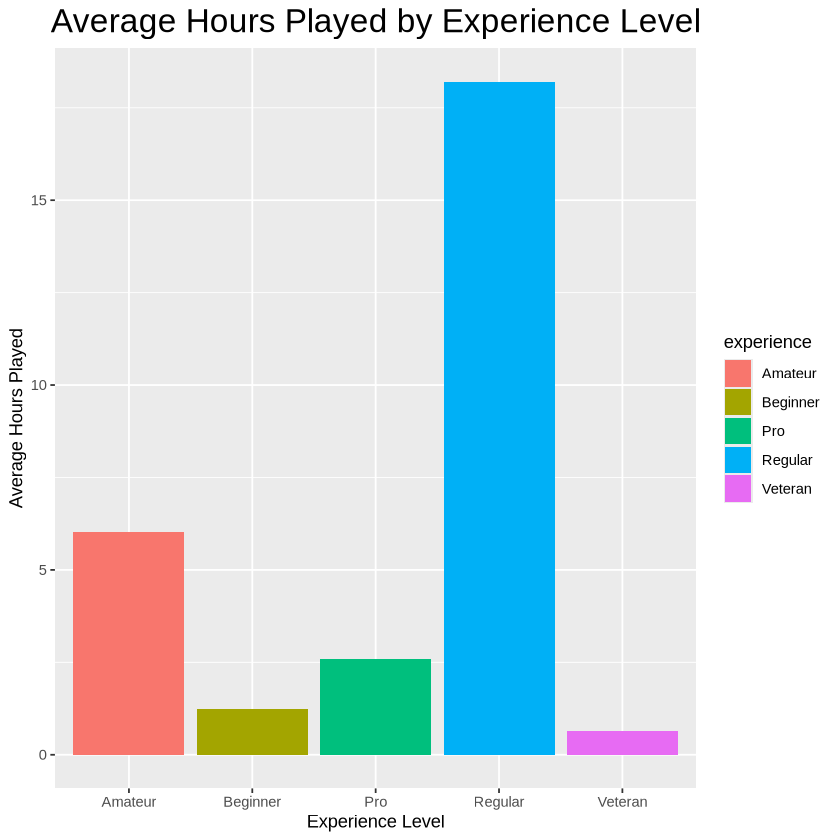

In [7]:
library(tidyverse) #load library
players <- read_csv("players.csv") #read .csv files
sessions <- read_csv("sessions.csv")

player_means <- players |> #calculate played hours
  select(where(is.numeric)) |>
  summarise(across(everything(), ~ round(mean(.x, na.rm = TRUE), 2)))

player_means_table <- player_means |> #tidy played hours tibble
  pivot_longer(everything(), names_to = "variable", values_to = "mean_value")

experience_vs_played_hours_plot <- players |> #played hours vs experience level visualization
                                group_by(experience) |>
                                summarize(mean_hours = mean(played_hours, na.rm = TRUE)) |>
                                ggplot(aes(x = experience, y = mean_hours, fill = experience)) +
                                geom_col() +
                                labs(title = "Average Hours Played by Experience Level",
                                x = "Experience Level",
                                y = "Average Hours Played") +
                                theme(plot.title = element_text(hjust = 0.5, size = 20))
experience_vs_played_hours_plot


Players with a Regular Experience level have the highest average hours played, experience level could be significant to the liklihood of subscription to a newsletterif average hours played is correlated to subscription. 

In [10]:
ptions(repr.plot.width = 15, repr.plot.height = 8)
gender_vs_played_hours_plot <- players |> #genger vs hours played visualization
                                group_by(gender) |>
                                summarize(mean_hours = mean(played_hours, na.rm = TRUE)) |>
                                ggplot(aes(x = gender, y = mean_hours, fill = gender)) +
                                geom_col() +
                                labs(title = "Average Hours Played by Gender",
                                x = "Gender",
                                y = "Average Hours Played") +
                                theme(plot.title = element_text(hjust = 0.5, size = 20))
gender_vs_played_hours_plot

ERROR: Error in ptions(repr.plot.width = 15, repr.plot.height = 8): could not find function "ptions"


Players identifying as non-binary have the highest average hours played, gender could be significant to the liklihood of subscription to a newsletter if average hours played is correlated to subscription. 